**EV Charger Station Feature**
- location: latitude, longitude

- capacity: capacity

- charger type: slow, fast

- mean trip: mean_trip

- road type(clip): Length of each type of link within a charging station 500m radius <br>
clip_length_city, clip_length_highway, clip_length_local, clip_length_national

- road_type(full): Total length of each type of link within the charging station 500m radius <br>
full_length_city, full_length_highway, full_length_local, full_length_national

- district_type: indust_ratio, etc_ratio, green_ratio, commerce_ratio, reside_ratio

### Create EV charger location Shapefile

In [2]:
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from osgeo import gdal

In [3]:
ev = pd.read_excel('ev_charger/ev_charger_location.xlsx')
ev

,시도,충전소명,경도,위도
0,강원도,강릉더샵 아파트,37.750646,128.909940
1,강원도,강릉특별지사,37.782175,128.918810
2,강원도,그린내하우스,37.760830,128.918984
3,강원도,봉평면사무소,37.616188,128.379730
4,강원도,강원도교육연수원,37.786442,128.918339
...,...,...,...,...
4773,충청북도,월악산 선착장,36.913451,128.067775
4774,충청북도,수안보연수원,36.843860,127.990674
4775,서울특별시,인재개발원,37.635199,127.087363
4776,전라북도,고창시험센터,35.455698,126.449479


In [2]:
ev.shape

(4778, 4)

In [3]:
gdf = gpd.GeoDataFrame(
    ev, geometry = list(map(lambda x: Point(x), ev[['위도', '경도']].values))
)

In [4]:
gdf.columns = ['city', 'ev_charger', 'latitude', 'longitude', 'geometry']

In [5]:
gdf.head()

,city,ev_charger,latitude,longitude,geometry
0,강원도,강릉더샵 아파트,37.750646,128.909940,POINT (128.90994 37.75065)
1,강원도,강릉특별지사,37.782175,128.918810,POINT (128.91881 37.78218)
2,강원도,그린내하우스,37.760830,128.918984,POINT (128.91898 37.76083)
3,강원도,봉평면사무소,37.616188,128.379730,POINT (128.37973 37.61619)
4,강원도,강원도교육연수원,37.786442,128.918339,POINT (128.91834 37.78644)


In [6]:
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf.to_file('ev_charger/ev_charger_location.shp', driver='ESRI Shapefile', encoding = 'cp949')

### Create qgis file to excel (After qgis preprocessing)

In [9]:
gdal.VectorTranslate('data/link-ev.csv', 'qgis/link_ev_mapping.gpkg', options = '-f CSV link_ev_mapping')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000247A33A94E0> >

In [8]:
link_ev = pd.read_csv('data/link-ev.csv')

C:\Users\058\AppData\Local\Temp\ipykernel_11276\202994321.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  link_ev = pd.read_csv('data/link-ev.csv')


In [9]:
link_ev = link_ev.loc[link_ev['ev_charger'].dropna().index, 
                 ['LINK_ID', 'F_NODE', 'T_NODE', 'LANES', 
                  'ROAD_RANK', 'ROAD_USE', 'MULTI_LINK', 
                  'city', 'ev_charger', 'latitude', 'longitude']]

In [10]:
link_ev

,LINK_ID,F_NODE,T_NODE,LANES,ROAD_RANK,ROAD_USE,MULTI_LINK,city,ev_charger,latitude,longitude
1,3620038802,3620008701,3620019000,2,107,0,0,경상북도,국민건강보험공단,36.358905,128.693289
15,3620041401,3620011200,3620011201,1,106,0,0,경상북도,농어촌공사 의성군위지사,36.392454,128.433796
24,3670140300,3670064400,3670063900,2,103,0,0,경상북도,성산득성리공용주차장,35.751929,128.372847
37,3620041707,3620008301,3620008307,1,106,0,0,경상북도,상리공영주차장,36.350173,128.704613
53,3620043302,3620068000,3620011300,1,106,0,0,경상북도,농어촌공사 의성군위지사,36.392454,128.433796
...,...,...,...,...,...,...,...,...,...,...,...
544405,1760139200,1760046000,1780005500,3,104,0,0,광주광역시,양동시장 공영주차장,35.152175,126.902945
544418,3670140400,3670063900,3670064400,2,103,0,0,경상북도,성산득성리공용주차장,35.751929,128.372847
544443,1220008103,1220015400,1220015600,3,104,0,0,서울특별시,샘터마을 아파트,37.485201,127.082675
544444,2380043500,2380012600,2380012300,2,103,0,0,경기도,전곡선사박물관,38.011780,127.067200


In [11]:
link_ev.to_csv('data/processed_link_ev.csv', index=False)

### 링크별 택시 통행량 -> 충전소별 택시 통행량

In [12]:
link_trip = pd.read_csv('data/link-trip.csv', encoding = 'cp949')

In [13]:
result_trip = pd.merge(link_ev, link_trip, left_on = 'LINK_ID', right_on = '링크아이디', how = 'left').groupby('ev_charger')[' 평균통행량 '].mean().reset_index()

In [14]:
result_trip.columns = ['ev_charger', 'mean_trip']

In [15]:
result_trip.to_csv('data/mean_trip.csv', index=False)

In [16]:
# 제외된 199개의 충전소의 mean_trip = 0.
result_trip

,ev_charger,mean_trip
0,(봉명)두진하트리움 아파트,332.878049
1,(주)케이에이치씨,1.465385
2,(주)플러스 전용 전기버스 충전소,198.237500
3,(청주방면)청송휴게소,45.950000
4,(춘천거두)초록지붕아파트,717.927778
...,...,...
4574,힐스테이트위례,196.667308
4575,힐스테이트자이논산,195.323188
4576,힐스테이트청계,332.708000
4577,힐스테이트황금산,132.800000


### 충전소별 도로 유형

In [17]:
gdal.VectorTranslate('data/road_type.csv', 'qgis/road_type.gpkg', options = '-f CSV _')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000202F9A06E40> >

In [18]:
link_ev = pd.read_csv('data/road_type.csv')
link_ev = link_ev[['ev_charger', 'LINK_ID', 'ROAD_RANK', 'clip_length', 'full_length']]
link_ev

,ev_charger,LINK_ID,ROAD_RANK,clip_length,full_length
0,강릉더샵 아파트,2520146500,107,82.412,82.440
1,강릉더샵 아파트,2520145901,107,42.750,42.764
2,강릉더샵 아파트,2520022302,107,155.931,155.986
3,강릉더샵 아파트,2520022402,107,205.175,205.246
4,강릉더샵 아파트,2520235900,107,53.883,53.901
...,...,...,...,...,...
307164,인재개발원,1100013802,104,266.450,266.451
307165,전력연구원,1860122100,104,268.538,526.210
307166,전력연구원,1860122200,104,266.114,529.648
307167,전력연구원,1860123500,104,1442.736,1623.833


In [19]:
def get_road_type(road_rank):
    if road_rank in [101, 102]:
        return 'highway'
    
    if road_rank in [103]:
        return 'national'
    
    if road_rank in [105, 106, 108]:
        return 'local'
    
    if road_rank in [104, 107]:
        return 'city'

In [20]:
link_ev['ROAD_TYPE'] = link_ev['ROAD_RANK'].map(get_road_type)

In [21]:
road_type_oh = pd.get_dummies(link_ev['ROAD_TYPE'], prefix = 'ROAD_TYPE')

In [22]:
road_type_oh

,ROAD_TYPE_city,ROAD_TYPE_highway,ROAD_TYPE_local,ROAD_TYPE_national
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
307164,1,0,0,0
307165,1,0,0,0
307166,1,0,0,0
307167,1,0,0,0


In [23]:
road_type_oh.sum(axis = 0)

ROAD_TYPE_city        278646
ROAD_TYPE_highway       4118
ROAD_TYPE_local         9586
ROAD_TYPE_national     14819
dtype: int64

In [24]:
link_ev = link_ev.groupby(['ev_charger', 'ROAD_TYPE'])['clip_length', 'full_length'].sum().reset_index()

C:\Users\058\AppData\Local\Temp\ipykernel_11276\1505025867.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  link_ev = link_ev.groupby(['ev_charger', 'ROAD_TYPE'])['clip_length', 'full_length'].sum().reset_index()


In [25]:
road_type_clip= link_ev.pivot(index='ev_charger', columns='ROAD_TYPE', values='clip_length').reset_index().fillna(0) \
                         .rename(columns={'city':'clip_length_city', 'highway':'clip_length_highway', 
                                          'local':'clip_length_local', 'national':'clip_length_national',})

road_type_full = link_ev.pivot(index='ev_charger', columns='ROAD_TYPE', values='full_length').reset_index().fillna(0) \
                            .rename(columns={'city':'full_length_city', 'highway':'full_length_highway',
                                                'local':'full_length_local', 'national':'full_length_national',})

In [26]:
road_type = pd.merge(road_type_clip, road_type_full, on = 'ev_charger', how = 'left')

In [27]:
road_type.to_csv('data/road_type.csv', index=False)

In [28]:
road_type = pd.read_csv('data/road_type.csv')
road_type

,ev_charger,clip_length_city,clip_length_highway,clip_length_local,clip_length_national,full_length_city,full_length_highway,full_length_local,full_length_national
0,(봉명)두진하트리움 아파트,28461.000,0.000,0.000,0.000,31074.994,0.000,0.000,0.000
1,(주)케이에이치씨,4986.158,0.000,0.000,0.000,7470.703,0.000,0.000,0.000
2,(주)플러스 전용 전기버스 충전소,3950.479,0.000,0.000,0.000,5040.637,0.000,0.000,0.000
3,(청주방면)청송휴게소,1995.452,1966.650,0.000,0.000,7379.704,4772.496,0.000,0.000
4,(춘천거두)초록지붕아파트,14990.105,0.000,0.000,0.000,15670.457,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...
4694,힐스테이트위례,11906.109,0.000,1602.515,0.000,12852.877,0.000,2778.717,0.000
4695,힐스테이트자이논산,15333.650,0.000,0.000,1274.642,15977.471,0.000,0.000,2871.430
4696,힐스테이트청계,13746.098,1683.834,0.000,0.000,16391.969,3445.650,0.000,0.000
4697,힐스테이트황금산,8270.593,0.000,0.000,2049.935,8700.286,0.000,0.000,2207.187


### 충전량, 충전타입 및 데이터 통합

In [29]:
import pandas as pd

In [30]:
mean_trip = pd.read_csv('data/mean_trip.csv')
mean_trip.columns = ['충전소명'] + mean_trip.columns[1:].values.tolist()
road_type = pd.read_csv('data/road_type.csv')
road_type.columns = ['충전소명'] + road_type.columns[1:].values.tolist()
capa = pd.read_csv('ev_charger/ev_charger_capacity.csv', encoding = 'cp949')
ctype = pd.read_csv('ev_charger/ev_charger_type.csv', encoding = 'cp949')
ev = pd.read_excel('ev_charger/ev_charger_location.xlsx')

C:\Users\058\AppData\Local\Temp\ipykernel_11276\3650395403.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  capa = pd.read_csv('ev_charger/ev_charger_capacity.csv', encoding = 'cp949')


In [31]:
# 통행량, 위도, 경도 통합
res_df = pd.merge(ev, mean_trip, on = '충전소명', how = 'right')
res_df = pd.merge(res_df, road_type, on = '충전소명', how = 'left')

In [32]:
# 충전소의 평균 공급 능력 계산
capa_df = capa.loc[capa['충전용량'].dropna().index, :]
capa_df = capa.groupby('충전소명')['충전용량'].mean().reset_index()
capa_df.columns = ['충전소명', 'capacity']

In [33]:
capa_df.isna().sum(axis = 0)

충전소명           0
capacity    2819
dtype: int64

In [34]:
# 통행량, 위도, 경도, 공급 능력 통합
res_df =  pd.merge(res_df, capa_df, on = '충전소명', how = 'right')

In [35]:
# qgis에서의 계산 방식은 링크와 주유소가 1:0~N 관계를 가지기 때문에 groupby 계산에서 null값이 생길 수 있다.
# 따라서, 통행량이 null인 충전소는 주변 500m 반경에 링크가 없는 충전소를 의미한다.
res_df = res_df.loc[res_df['mean_trip'].dropna().index, :]

In [36]:
res_df

,시도,충전소명,경도,위도,mean_trip,clip_length_city,clip_length_highway,clip_length_local,clip_length_national,full_length_city,full_length_highway,full_length_local,full_length_national,capacity
1,충청북도,(봉명)두진하트리움 아파트,36.652163,127.458088,332.878049,28461.000,0.000,0.000,0.000,31074.994,0.000,0.000,0.000,7.000000
3,경기도,(주)플러스 전용 전기버스 충전소,37.649296,126.643509,198.237500,3950.479,0.000,0.000,0.000,5040.637,0.000,0.000,0.000,80.865522
4,경상북도,(청주방면)청송휴게소,36.456848,129.011834,45.950000,1995.452,1966.650,0.000,0.000,7379.704,4772.496,0.000,0.000,100.000000
5,강원도,(춘천거두)초록지붕아파트,37.853709,127.752074,717.927778,14990.105,0.000,0.000,0.000,15670.457,0.000,0.000,0.000,7.000000
8,세종특별자치시,2생활권 환승주차장2(B),36.481431,127.262150,19.000000,17993.543,0.000,2301.871,0.000,20907.342,0.000,2612.449,0.000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6844,경기도,힐스테이트위례,37.464375,127.144134,196.667308,11906.109,0.000,1602.515,0.000,12852.877,0.000,2778.717,0.000,50.000000
6845,충청남도,힐스테이트자이논산,36.181891,127.101681,195.323188,15333.650,0.000,0.000,1274.642,15977.471,0.000,0.000,2871.430,7.000000
6846,서울특별시,힐스테이트청계,37.571543,127.045904,332.708000,13746.098,1683.834,0.000,0.000,16391.969,3445.650,0.000,0.000,50.000000
6847,경기도,힐스테이트황금산,37.608221,127.163637,132.800000,8270.593,0.000,0.000,2049.935,8700.286,0.000,0.000,2207.187,15.068884


In [37]:
ctype['충전방식'] = ctype['충전방식'].apply(lambda x: str(x)[-3:-1])
ctype.loc[ctype['충전방식'] == 'na', '충전방식'] = ctype[ctype['충전방식'] == 'na']['충전기명'].apply(lambda x: x[:2])
bus = 'DC콤보+DC콤보(전기버스)'
ctype.loc[ctype['충전방식'] == '버스', '충전방식'] = ctype[ctype['충전방식'] == '버스']['충전기명'].apply(lambda x: x[:2])

In [38]:
ctype.to_csv('data/ctype.csv', index = False)

In [39]:
ctype_df = pd.concat([ctype[['충전소명']], pd.get_dummies(ctype['충전방식'])], axis = 1).groupby('충전소명').sum().reset_index()

In [40]:
ctype_df

,충전소명,급속,완속
0,(봉명)두진하트리움 아파트,0,2
1,(주)케이에이치씨,1,0
2,(주)플러스 전용 전기버스 충전소,6,0
3,(청주방면)청송휴게소,1,0
4,(춘천거두)초록지붕아파트,0,5
...,...,...,...
4711,힐스테이트위례,1,0
4712,힐스테이트자이논산,0,3
4713,힐스테이트청계,1,0
4714,힐스테이트황금산,1,3


In [41]:
res_df = pd.merge(res_df, ctype_df, on = '충전소명', how = 'left')
res_df.columns = ['city', 'sid', 'latitude', 'longitude'] + res_df.columns[4:-2].values.tolist() + ['fast', 'slow']

In [42]:
res_df = res_df[['sid', 'city', 'latitude','longitude', 'capacity', 'slow', 'fast', 'mean_trip', 
                 'clip_length_city', 'clip_length_highway', 'clip_length_local', 'clip_length_national',
                 'full_length_city', 'full_length_highway', 'full_length_local', 'full_length_national',]]

In [43]:
res_df.drop('city', axis = 1, inplace = True)
res_df

,sid,latitude,longitude,capacity,slow,fast,mean_trip,clip_length_city,clip_length_highway,clip_length_local,clip_length_national,full_length_city,full_length_highway,full_length_local,full_length_national
0,(봉명)두진하트리움 아파트,36.652163,127.458088,7.000000,2.0,0.0,332.878049,28461.000,0.000,0.000,0.000,31074.994,0.000,0.000,0.000
1,(주)플러스 전용 전기버스 충전소,37.649296,126.643509,80.865522,0.0,6.0,198.237500,3950.479,0.000,0.000,0.000,5040.637,0.000,0.000,0.000
2,(청주방면)청송휴게소,36.456848,129.011834,100.000000,0.0,1.0,45.950000,1995.452,1966.650,0.000,0.000,7379.704,4772.496,0.000,0.000
3,(춘천거두)초록지붕아파트,37.853709,127.752074,7.000000,5.0,0.0,717.927778,14990.105,0.000,0.000,0.000,15670.457,0.000,0.000,0.000
4,2생활권 환승주차장2(B),36.481431,127.262150,50.000000,0.0,2.0,19.000000,17993.543,0.000,2301.871,0.000,20907.342,0.000,2612.449,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,힐스테이트위례,37.464375,127.144134,50.000000,0.0,1.0,196.667308,11906.109,0.000,1602.515,0.000,12852.877,0.000,2778.717,0.000
4031,힐스테이트자이논산,36.181891,127.101681,7.000000,3.0,0.0,195.323188,15333.650,0.000,0.000,1274.642,15977.471,0.000,0.000,2871.430
4032,힐스테이트청계,37.571543,127.045904,50.000000,0.0,1.0,332.708000,13746.098,1683.834,0.000,0.000,16391.969,3445.650,0.000,0.000
4033,힐스테이트황금산,37.608221,127.163637,15.068884,3.0,1.0,132.800000,8270.593,0.000,0.000,2049.935,8700.286,0.000,0.000,2207.187


In [44]:
res_df.isna().sum(axis = 0)

sid                       0
latitude                  0
longitude                 0
capacity                391
slow                      9
fast                      9
mean_trip                 0
clip_length_city          0
clip_length_highway       0
clip_length_local         0
clip_length_national      0
full_length_city          0
full_length_highway       0
full_length_local         0
full_length_national      0
dtype: int64

In [45]:
res_df.to_csv('data/input_except_district.csv', index=False)

### Public Station

In [46]:
import pandas as pd
public_df = pd.read_csv('ev_charger/ev_charger_type.csv', encoding = 'cp949').rename(columns = {'충전소명':'sid'})
df = pd.read_csv('data/input_except_district.csv')

In [47]:
df.isna().sum(axis = 0)

sid                       0
latitude                  0
longitude                 0
capacity                391
slow                      9
fast                      9
mean_trip                 0
clip_length_city          0
clip_length_highway       0
clip_length_local         0
clip_length_national      0
full_length_city          0
full_length_highway       0
full_length_local         0
full_length_national      0
dtype: int64

In [48]:
public_df = pd.merge(df, public_df[['sid', '충전소구분']], on = 'sid', how = 'left').drop_duplicates(subset=['sid'])
public_df = public_df[public_df['충전소구분'] == '공용']

In [49]:
public_df.dropna(inplace = True)

In [50]:
public_df.to_csv('data/public_station.csv', index=False)

### District type

In [51]:
gdal.VectorTranslate('data/evs_district.csv', 'qgis/station_district.gpkg')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000020287083810> >

In [52]:
district = pd.read_csv('data/evs_district.csv')
district

,id,ev_charger,latitude,longitude,A1,area
0,1,롯데캐슬프레지던트,37.544865,126.950739,31300001144020130043UQA2200223020,13465.961
1,2,롯데캐슬프레지던트,37.544865,126.950739,15000001144020040001UQA1220001001,108.583
2,3,롯데캐슬프레지던트,37.544865,126.950739,61100001144020150134UQA1220521003,1123.663
3,4,롯데캐슬프레지던트,37.544865,126.950739,15000001144000000000UQA1300008008,20737.624
4,5,창전삼성 아파트,37.551292,126.931494,15000001144020039228UQA1220001001,43.989
...,...,...,...,...,...,...
59707,59708,롯데캐슬프레지던트,37.544865,126.950739,15000001144000000000UQA1300028028,18189.694
59708,59709,롯데캐슬프레지던트,37.544865,126.950739,15000001144000000000UQA1300002002,19839.871
59709,59710,롯데캐슬프레지던트,37.544865,126.950739,15000001144020039271UQA1230001001,930.990
59710,59711,롯데캐슬프레지던트,37.544865,126.950739,61100001144020070241UQA1220007019,1248.431


<Axes: ylabel='Frequency'>

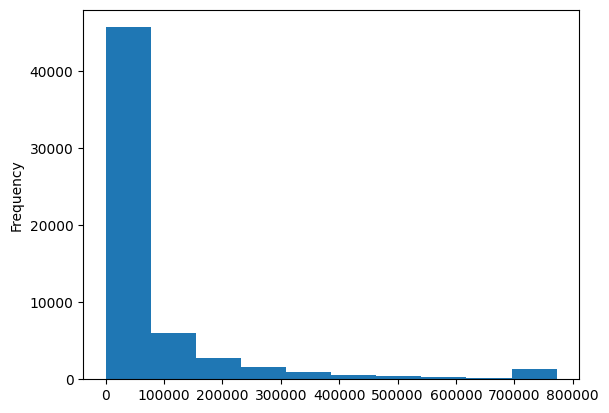

In [53]:
import matplotlib.pyplot as plt
district.area.plot(kind='hist')

In [54]:
district.drop(['id', 'latitude', 'longitude'], axis = 1, inplace = True)
district.columns = ['sid', 'dcode', 'area']
district

,sid,dcode,area
0,롯데캐슬프레지던트,31300001144020130043UQA2200223020,13465.961
1,롯데캐슬프레지던트,15000001144020040001UQA1220001001,108.583
2,롯데캐슬프레지던트,61100001144020150134UQA1220521003,1123.663
3,롯데캐슬프레지던트,15000001144000000000UQA1300008008,20737.624
4,창전삼성 아파트,15000001144020039228UQA1220001001,43.989
...,...,...,...
59707,롯데캐슬프레지던트,15000001144000000000UQA1300028028,18189.694
59708,롯데캐슬프레지던트,15000001144000000000UQA1300002002,19839.871
59709,롯데캐슬프레지던트,15000001144020039271UQA1230001001,930.990
59710,롯데캐슬프레지던트,61100001144020070241UQA1220007019,1248.431


In [55]:
district['dcode'] = district['dcode'].map(lambda x: x[20:26] if x is not np.nan else x) \
                                  .map(lambda x: 'UQA500' if x ==  'UAQ500'  else x)

In [56]:
district.isna().sum(axis = 0)

sid         0
dcode    3579
area        0
dtype: int64

In [57]:
district

,sid,dcode,area
0,롯데캐슬프레지던트,UQA220,13465.961
1,롯데캐슬프레지던트,UQA122,108.583
2,롯데캐슬프레지던트,UQA122,1123.663
3,롯데캐슬프레지던트,UQA130,20737.624
4,창전삼성 아파트,UQA122,43.989
...,...,...,...
59707,롯데캐슬프레지던트,UQA130,18189.694
59708,롯데캐슬프레지던트,UQA130,19839.871
59709,롯데캐슬프레지던트,UQA123,930.990
59710,롯데캐슬프레지던트,UQA122,1248.431


In [58]:
dqm = pd.read_csv('data/processed_dcode.csv')

In [59]:
dqm

,dcode,dname
0,UQA000,도시지역미분류 (4)
1,UQA001,도시지역 (5)
2,UQA100,주거지역 (6)
3,UQA110,전용주거지역 (7)
4,UQA111,제1종전용주거지역 (8)
...,...,...
349,FUMR100,특정도서 (388)
350,FUMS220,야생동식물보호구역 (389)
351,FUOC100,문화재보호구역 (390)
352,FUQA410,보전녹지지역 (391)


In [60]:
def decode_grouper(name):
    if '주거' in name:
        return '주거지역'
    if '상업' in name:
        return '상업지역'
    if '녹지' in name:
        return '녹지지역'
    if '공업' in name:
        return '공업지역'
    return '기타'


dqm.dname = dqm.dname.map(decode_grouper)
dqm

,dcode,dname
0,UQA000,기타
1,UQA001,기타
2,UQA100,주거지역
3,UQA110,주거지역
4,UQA111,주거지역
...,...,...
349,FUMR100,기타
350,FUMS220,기타
351,FUOC100,기타
352,FUQA410,녹지지역


In [61]:
dqm.dname.value_counts()

기타      322
주거지역     11
녹지지역     10
공업지역      6
상업지역      5
Name: dname, dtype: int64

In [62]:
set(district.dcode.values.tolist()) - set(dqm.dcode.values.tolist())

{'UQA01X', nan}

In [63]:
dqm = dqm.append({'dcode':'UQA01X', 'dname':'기타'}, ignore_index=True)

C:\Users\058\AppData\Local\Temp\ipykernel_11276\1063060376.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dqm = dqm.append({'dcode':'UQA01X', 'dname':'기타'}, ignore_index=True)


In [64]:
district = pd.merge(district, dqm, on = 'dcode', how = 'left')
district

,sid,dcode,area,dname
0,롯데캐슬프레지던트,UQA220,13465.961,상업지역
1,롯데캐슬프레지던트,UQA122,108.583,주거지역
2,롯데캐슬프레지던트,UQA122,1123.663,주거지역
3,롯데캐슬프레지던트,UQA130,20737.624,주거지역
4,창전삼성 아파트,UQA122,43.989,주거지역
...,...,...,...,...
59707,롯데캐슬프레지던트,UQA130,18189.694,주거지역
59708,롯데캐슬프레지던트,UQA130,19839.871,주거지역
59709,롯데캐슬프레지던트,UQA123,930.990,주거지역
59710,롯데캐슬프레지던트,UQA122,1248.431,주거지역


In [65]:
district = district.groupby(['sid', 'dname']).area.sum().to_frame().reset_index()

In [66]:
def normalize_area(sid_df):
        sid_df.area = sid_df.area / sid_df.area.sum()
        return sid_df

district = district.groupby('sid', group_keys=False).apply(normalize_area) 

In [67]:
district

,sid,dname,area
0,(봉명)두진하트리움 아파트,공업지역,0.794867
1,(봉명)두진하트리움 아파트,녹지지역,0.055038
2,(봉명)두진하트리움 아파트,주거지역,0.150095
3,(주)케이에이치씨,공업지역,1.000000
4,(주)플러스 전용 전기버스 충전소,녹지지역,0.905987
...,...,...,...
12605,힐스테이트황금산,상업지역,0.065603
12606,힐스테이트황금산,주거지역,0.525544
12607,힐즈파크푸르지오2단지,기타,0.001868
12608,힐즈파크푸르지오2단지,녹지지역,0.462516


In [68]:
district_ratio = district.pivot(index='sid', columns='dname', values='area').reset_index().fillna(0) \
                         .rename(columns={'공업지역':'indust_ratio', '기타':'etc_ratio', '녹지지역':'green_ratio', '상업지역':'commerce_ratio', '주거지역':'reside_ratio'})

district_ratio

dname,sid,indust_ratio,etc_ratio,green_ratio,commerce_ratio,reside_ratio
0,(봉명)두진하트리움 아파트,0.794867,0.000000,0.055038,0.000000,0.150095
1,(주)케이에이치씨,1.000000,0.000000,0.000000,0.000000,0.000000
2,(주)플러스 전용 전기버스 충전소,0.000000,0.000000,0.905987,0.000000,0.094013
3,(춘천거두)초록지붕아파트,0.000000,0.000000,0.344327,0.000000,0.655673
4,2생활권 환승주차장1(A),0.000000,0.000000,0.154957,0.517915,0.327128
...,...,...,...,...,...,...
4374,힐스테이트위례,0.000000,0.000000,0.293213,0.224089,0.482698
4375,힐스테이트자이논산,0.000000,0.000000,0.437566,0.000000,0.562434
4376,힐스테이트청계,0.000000,0.500000,0.000000,0.011307,0.488693
4377,힐스테이트황금산,0.000000,0.000000,0.408853,0.065603,0.525544


In [69]:
input_df = pd.read_csv('data/public_station.csv')
input_df = pd.merge(input_df, district_ratio, on = 'sid', how = 'left').dropna()
input_df.drop('충전소구분', axis = 1, inplace = True)
input_df

,sid,latitude,longitude,capacity,slow,fast,mean_trip,clip_length_city,clip_length_highway,clip_length_local,clip_length_national,full_length_city,full_length_highway,full_length_local,full_length_national,indust_ratio,etc_ratio,green_ratio,commerce_ratio,reside_ratio
1,2생활권 환승주차장2(B),36.481431,127.262150,50.000000,0.0,2.0,19.000000,17993.543,0.000,2301.871,0.000,20907.342,0.000,2612.449,0.000,0.000000,0.000000,0.080512,0.626226,0.293262
2,2호선 양산역,35.339621,129.026993,50.000000,0.0,2.0,336.122549,19059.198,0.000,1556.374,0.000,20614.296,0.000,2135.674,0.000,0.000000,0.000000,0.417485,0.200592,0.381923
3,3호선 칠곡차량기지,35.960892,128.558904,36.257732,1.0,1.0,107.992308,6519.452,4390.483,0.000,0.000,9057.522,4856.165,0.000,0.000,0.000000,0.002473,0.896504,0.000000,0.101023
4,CGV 신대점,34.926630,127.552580,100.000000,0.0,3.0,80.239216,6508.790,0.000,1935.870,1777.558,8242.538,0.000,2980.956,2744.388,0.032381,0.000000,0.437079,0.000000,0.530540
5,G-Tower(경제자유구역청),37.396513,126.633746,79.597701,0.0,4.0,177.000000,14620.884,0.000,0.000,0.000,15977.304,0.000,0.000,0.000,0.000000,0.000000,0.208159,0.514251,0.277590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,회인면사무소,36.494632,127.596769,50.000000,0.0,1.0,55.142857,1581.975,1789.274,0.000,2044.499,2048.959,6635.793,0.000,5667.634,0.000000,0.000000,0.679932,0.060775,0.259293
1226,회천1동주민센터,37.844233,127.066058,50.000000,0.0,1.0,73.234821,11104.431,0.000,2649.829,0.000,15178.263,0.000,3343.787,0.000,0.010901,0.000000,0.429507,0.040222,0.519370
1227,횡성국민체육센터,37.488383,127.973527,50.000000,0.0,1.0,29.017857,8497.977,0.000,0.000,572.119,9514.678,0.000,0.000,2860.433,0.000000,0.000000,0.780534,0.000000,0.219466
1228,효자종합시장공영주차장,36.007500,129.329015,50.000000,0.0,1.0,369.883333,11901.942,0.000,0.000,3873.828,14367.805,0.000,0.000,5119.608,0.000000,0.000000,0.519884,0.000000,0.480116


In [ ]:
input_df.to_csv('data/evcs_attributes.csv', index = False)

### Scaling

In [3]:
evcs = pd.read_csv('data/evcs_attributes.csv')
evcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sid                   1052 non-null   object 
 1   latitude              1052 non-null   float64
 2   longitude             1052 non-null   float64
 3   capacity              1052 non-null   float64
 4   slow                  1052 non-null   float64
 5   fast                  1052 non-null   float64
 6   mean_trip             1052 non-null   float64
 7   clip_length_city      1052 non-null   float64
 8   clip_length_highway   1052 non-null   float64
 9   clip_length_local     1052 non-null   float64
 10  clip_length_national  1052 non-null   float64
 11  full_length_city      1052 non-null   float64
 12  full_length_highway   1052 non-null   float64
 13  full_length_local     1052 non-null   float64
 14  full_length_national  1052 non-null   float64
 15  indust_ratio         

In [26]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

scaler = MinMaxScaler((-1,1))
# scaler = RobustScaler()

X_total = evcs.drop('sid', axis = 1)
X_total = scaler.fit_transform(X_total)

X_clip = evcs.drop(['sid', 'full_length_city', 'full_length_highway', 'full_length_local', 'full_length_national'], axis = 1)
X_clip = scaler.fit_transform(X_clip)

X_full = evcs.drop(['sid', 'clip_length_city', 'clip_length_highway', 'clip_length_local', 'clip_length_national'], axis = 1)
X_full = scaler.fit_transform(X_full)

In [27]:
import umap

trans_total = umap.UMAP(n_neighbors=5, n_components=2, metric='euclidean', random_state=42).fit(X_total)

C:\Users\058\AppData\Local\Temp\ipykernel_1300\976820123.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(trans_total.embedding_[:, 0], trans_total.embedding_[:, 1], s= 5, cmap='Spectral')


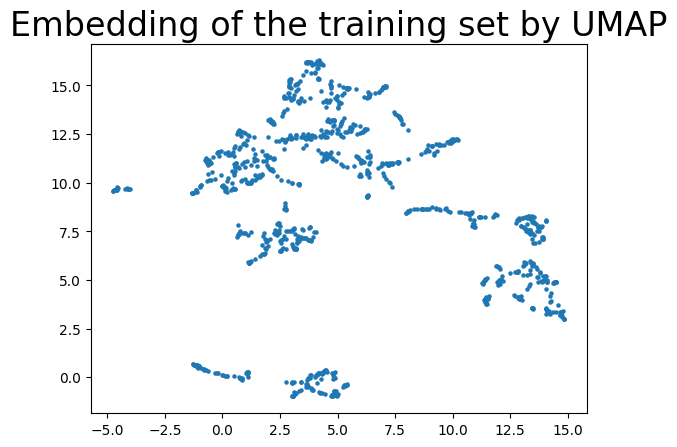

In [28]:
import matplotlib.pyplot as plt

plt.scatter(trans_total.embedding_[:, 0], trans_total.embedding_[:, 1], s= 5, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

In [29]:
trans_total = umap.UMAP(n_neighbors=5, n_components=8, metric='euclidean', random_state=42).fit(X_total)
trans_clip = umap.UMAP(n_neighbors=5, n_components=8, metric='euclidean', random_state=42).fit(X_clip)
trans_full = umap.UMAP(n_neighbors=5, n_components=8, metric='euclidean', random_state=42).fit(X_full)

In [30]:
evcs_embed_total = pd.DataFrame(data=trans_total.embedding_, index=evcs.sid, columns=[ 'umap_' + str(i+1) for i in range(8)]).reset_index()
evcs_embed_clip = pd.DataFrame(data=trans_clip.embedding_, index=evcs.sid, columns=[ 'umap_' + str(i+1) for i in range(8)]).reset_index()
evcs_embed_full = pd.DataFrame(data=trans_full.embedding_, index=evcs.sid, columns=[ 'umap_' + str(i+1) for i in range(8)]).reset_index()

In [31]:
evcs_embed_total

,sid,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8
0,2생활권 환승주차장2(B),4.311143,8.873408,6.077338,9.774128,6.147580,7.859995,5.486022,5.089606
1,2호선 양산역,2.886745,9.296528,7.404665,7.023818,7.530702,7.158869,5.379786,4.567728
2,3호선 칠곡차량기지,4.334510,9.024877,6.954717,6.120275,8.130526,5.553605,5.650456,4.430954
3,CGV 신대점,6.219264,5.011050,0.099318,7.967574,5.886210,7.002373,6.200799,5.422480
4,G-Tower(경제자유구역청),4.420022,8.761160,5.855635,9.792497,6.133898,7.869627,5.542234,5.002951
...,...,...,...,...,...,...,...,...,...
1047,회인면사무소,4.401660,8.966839,6.740232,6.466672,7.918063,5.915380,5.626467,4.390295
1048,회천1동주민센터,2.447063,9.413750,6.766768,8.689561,8.742271,7.078540,5.869754,7.652469
1049,횡성국민체육센터,3.170024,9.751380,5.994272,6.651130,8.001356,6.767337,5.781693,4.080522
1050,효자종합시장공영주차장,3.004566,9.410018,7.211855,6.950500,7.402294,7.160913,5.408037,4.340036


In [32]:
evcs_embed_total.to_csv('data/evcs_embedding_(clip+full).csv', index=False)
evcs_embed_clip.to_csv('data/evcs_embedding_clip.csv', index=False)
evcs_embed_full.to_csv('data/evcs_embedding_full.csv', index=False)

### Target Feature Preparation

In [71]:
capa = pd.read_csv('ev_charger/ev_charger_capacity.csv', encoding = 'cp949')
input = pd.read_csv('data/ev_charger_station_features.csv')

C:\Users\058\AppData\Local\Temp\ipykernel_11276\3684483978.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  capa = pd.read_csv('ev_charger/ev_charger_capacity.csv', encoding = 'cp949')


In [72]:
capa_df = capa[capa.충전소명.isin(input.sid)]
capa_df = capa_df[['충전소명', '충전기구분', '충전시간', '충전분', '충전시작시각', '충전종료시각']]
capa_df.columns = ['sid', 'ctype', 'hour', 'minute', 'start_time', 'end_time']

In [73]:
capa_df['duration'] = capa_df['hour']*60 + capa_df['minute']

In [74]:
capa_df.describe()

,hour,minute,duration
count,326323.000000,326323.000000,326323.000000
mean,0.444753,28.185549,54.870705
std,1.080645,17.075868,64.156725
min,0.000000,0.000000,0.000000
25%,0.000000,14.000000,27.000000
50%,0.000000,28.000000,46.000000
75%,1.000000,42.000000,70.000000
max,265.000000,59.000000,15942.000000


In [75]:
fast_df = capa_df[capa_df['ctype'] == '급속']

In [76]:
import numpy as np

def outlier_bound(array):
    stdev = np.std(array)
    med = np.median(array)
    return med - 3*stdev, med + 3*stdev

outlier_bound(fast_df.duration)

(-122.62402184315164, 214.62402184315164)

In [77]:
outlier_sid = fast_df[fast_df.duration.gt(outlier_bound(fast_df.duration)[1])]

In [78]:
fast_df = fast_df[~fast_df.sid.isin(outlier_sid)]

In [79]:
capa_df

,sid,ctype,hour,minute,start_time,end_time,duration
0,국민체육센터,급속,0,40,2022-01-01 09:51:51,2022-01-01 10:31:51,40
1,국민체육센터,급속,0,40,2022-01-01 10:33:43,2022-01-01 11:13:43,40
2,동두천지사,급속,0,21,2022-01-01 18:38:26,2022-01-01 18:59:43,21
3,동두천지사,급속,1,55,2022-01-01 19:10:29,2022-01-01 21:05:43,115
4,동두천지사,급속,0,1,2022-01-01 12:33:09,2022-01-01 12:34:36,1
...,...,...,...,...,...,...,...
1048562,한국생산기술연구소 전기차충전소,급속,0,31,2022-03-30 13:08:51,2022-03-30 13:40:18,31
1048566,경북대학교(대구캠퍼스),급속,0,57,2022-03-30 21:15:44,2022-03-30 22:13:09,57
1048569,공지천 공영주차장,급속,1,0,2022-03-30 21:15:44,2022-03-30 22:15:52,60
1048571,서귀포시교육지원청,급속,0,14,2022-03-30 16:04:36,2022-03-30 16:19:10,14


In [85]:
fast_df

,sid,ctype,hour,minute,start_time,end_time,duration
0,국민체육센터,급속,0,40,2022-01-01 09:51:51,2022-01-01 10:31:51,40
1,국민체육센터,급속,0,40,2022-01-01 10:33:43,2022-01-01 11:13:43,40
2,동두천지사,급속,0,21,2022-01-01 18:38:26,2022-01-01 18:59:43,21
3,동두천지사,급속,1,55,2022-01-01 19:10:29,2022-01-01 21:05:43,115
4,동두천지사,급속,0,1,2022-01-01 12:33:09,2022-01-01 12:34:36,1
...,...,...,...,...,...,...,...
1048562,한국생산기술연구소 전기차충전소,급속,0,31,2022-03-30 13:08:51,2022-03-30 13:40:18,31
1048566,경북대학교(대구캠퍼스),급속,0,57,2022-03-30 21:15:44,2022-03-30 22:13:09,57
1048569,공지천 공영주차장,급속,1,0,2022-03-30 21:15:44,2022-03-30 22:15:52,60
1048571,서귀포시교육지원청,급속,0,14,2022-03-30 16:04:36,2022-03-30 16:19:10,14


### Target Feature Generation